In [45]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import pandas as pd
import time

from pypcd4 import PointCloud
from scipy.spatial.transform import Rotation
from scipy.stats import multivariate_normal
from typing import List, Tuple
from tqdm import tqdm

sys.path.append("../")

# Load the pcd from the map.pcd file

In [46]:
def pcd_from_path(file_path: str) -> np.ndarray:
    """
    Loads point clouds from PCD files using the PointCloud library (assumed to be open3d or similar).

    Parameters:
        file_path (str): Path to a .pcd file.

    Returns:
        np.ndarray: Numpy array representing the point cloud, shape [n_points, m_channels].
    
    Raises:
        ValueError: If the file format is not 'pcd'.
        FileNotFoundError: If the file does not exist.
    """
    if not file_path.endswith(".pcd"):
        raise ValueError('Only ".pcd" format is accepted.')
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    
    pc = PointCloud.from_path(file_path)
    return pc.numpy()

# Downsample to voxels

In [47]:
def downsample_voxel(map_array: np.ndarray, voxel_size: float):
    """
    Downsamples a pointcloud using a voxel grid, and provides voxel configurations.

    Args:
    - map_array (np.ndarray): Input point cloud as an Nx3 numpy array.
    - voxel_size (float): Desired voxel size for downsampling.

    Returns:
    - Tuple[np.ndarray, dict]: Downsampled point cloud as an Nx3 numpy array,
                               and a dictionary with voxel configuration details.
    """
    # drop points which are too close to the ground
    # map_array = map_array[map_array[:, 2] > -1]

    # Convert np array to open3D pointcloud
    map_pcd = o3d.geometry.PointCloud()
    map_pcd.points = o3d.utility.Vector3dVector(map_array)
    
    # Use open3D voxelisation utility with desired voxel_size
    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(map_pcd, voxel_size)
    
    # Get coordinates of the voxels that are points of the downsampled grid
    indices = np.array([voxel.grid_index for voxel in voxel_grid.get_voxels()], dtype=float) * voxel_size

    # Calculate voxel configuration details
    max_bound = voxel_grid.get_max_bound()
    min_bound = voxel_grid.get_min_bound()
    voxel_config = {
        'voxel_bounds': {'min': 0, 'max': indices.max(axis=0)},
        'real_bounds': {'min': min_bound, 'max': max_bound}
    }

    # Adjust indices to represent real-world coordinates (center of each voxel)
    indices += min_bound + voxel_size / 2

    return indices, voxel_config

In [48]:
def boundaries(map_array: np.ndarray, r: float = 2.5, n_iter: int = 2000, zlims: Tuple[float, float] = (-1, 7), device_str: str = "CPU:0") -> np.ndarray:
    """
    Detects boundaries in a voxelized point cloud and trims the results within specified z-limits.

    Args:
    - map_array (np.ndarray): Voxelized point cloud, shape (Nr_points, 3).
    - r (float): Radius to consider points as part of the same object.
    - n_iter (int): Number of iterations for edge detection.
    - zlims (Tuple[float, float]): Minimum and maximum z-values to consider.
    - device_str (str): Device identifier for computation.

    Returns:
    - np.ndarray: Point cloud containing detected boundaries, shape (Nr_points_downsampled, 3).
    """
    # Set up the computation device and data type
    device = o3d.core.Device(device_str)
    dtype = o3d.core.Dtype.Float32

    # Initialize an empty point cloud on the specified device
    tensor_map = o3d.t.geometry.PointCloud(device)

    # Assign data to point cloud
    tensor_map.point['positions'] = o3d.core.Tensor(map_array, dtype, device)

    # Estimate normals for the point cloud
    tensor_map.estimate_normals()

    # Calculate the boundaries of the point cloud using the provided radius and iterations
    boundaries, _ = tensor_map.compute_boundary_points(r, n_iter)

    # Extract the boundary points as a NumPy array
    np_boundaries = boundaries.point['positions'].numpy()

    # Apply z-limits to filter the point cloud
    z_filter = (np_boundaries[:, 2] > zlims[0]) & (np_boundaries[:, 2] < zlims[1])
    np_boundaries = np_boundaries[z_filter]

    return np_boundaries

In [49]:
def to_2D(pc: np.ndarray) -> np.ndarray:
    """
    Prone the z-dimension from the point cloud.

    Args:
    - pc (np.ndarray): Voxelized point cloud, shape (Nr_points, 3).

    Returns:
    - np.ndarray: Point cloud containing first 2 dimensions size (Nr_points_downsampled, 2).
    """
    return pc[:, :2]

# Plot 2D

In [50]:
def plot_pcd(ax: plt.Axes, points: np.ndarray, **kwargs):
    """
    Plots point cloud data on a given matplotlib axis.

    Parameters:
        ax (matplotlib.axes.Axes): The axes on which to plot the point cloud.
        points (np.ndarray): The point cloud data, expected shape [n_points, at least 2].
        **kwargs: Additional keyword arguments passed to matplotlib scatter plot.

    Raises:
        ValueError: If 'points' does not have the correct dimensions.
    """
    if points.ndim < 2 or points.shape[1] < 2:
        raise ValueError("The 'points' array must have at least two dimensions [n_points, at least 2].")

    return ax.scatter(points[:, 0], points[:, 1], **kwargs)

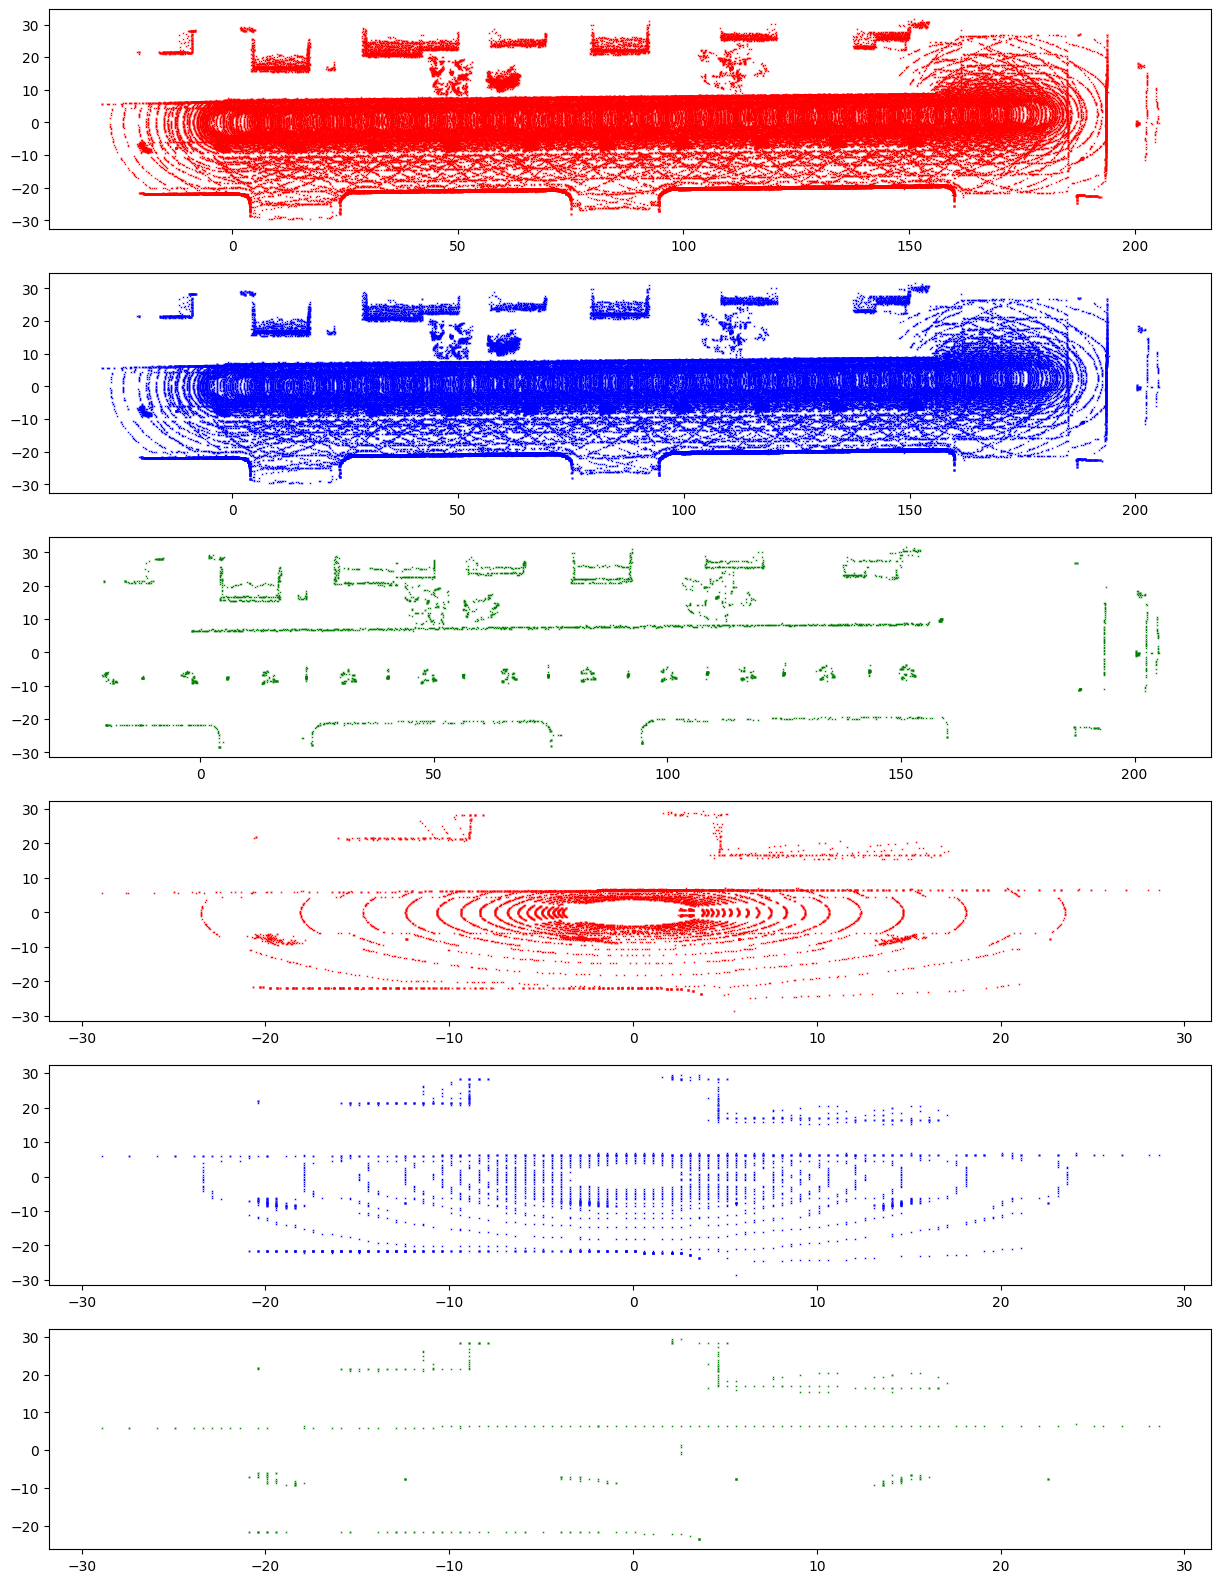

In [51]:
map_array = pcd_from_path("../dataset/map.pcd")

fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,1, figsize=(15, 20))
voxel_map, voxel_config_show = downsample_voxel(map_array, voxel_size=0.2)
bounded_map = boundaries(voxel_map, r=5, n_iter=1000, zlims=[-1, 7])

current_frames = np.empty(1013, dtype=object)
voxel_frames=np.empty(1013, dtype=object)
bounded_frames=np.empty(1013, dtype=object)

for frame in range (0,10): #range(0, 1013):
    current_frames[frame] = pcd_from_path("../dataset/frames/frame_"+str(frame)+".pcd")
    voxel_frames[frame], _ = downsample_voxel(current_frames[frame], voxel_size=0.5)
    bounded_frames[frame] = boundaries(voxel_frames[frame], r=2.5, zlims=[-1, 7])

plot_pcd(ax1, map_array, color="red", label="Target", marker='x',s=.10)
plot_pcd(ax2, voxel_map, color="blue", label="Target", marker='x',s=.10)
plot_pcd(ax3, bounded_map, color="green", label="Target", marker='x',s=.10)

plot_pcd(ax4, current_frames[0], color="red", label="Target", marker='x',s=.10)
plot_pcd(ax5, voxel_frames[0], color="blue", label="Target", marker='x',s=.10)
plot_pcd(ax6, bounded_frames[0], color="green", label="Target", marker='x',s=.10)


# NDT Implementation

In [80]:
class Pose:
    """
    Pose class
    """
    def __init__(self, x:float,y:float,yaw:float):
        """
        Constructor of the class

        Args:
            x (float): X offset of the pose
            y (float): Y offset of the pose
            yaw (float): Yaw angle of the pose
        """
        self.x = x
        self.y = y
        self.yaw = yaw
    
    def get_transformation(self)->Tuple[np.array, np.array]:
        """
        Method to obtain the Rotation matrix and translation 
        vector of a given pose.

        Returns:
            Tuple[np.array, np.array]: Rotation as a 2x2 matrix
                                       translation vector as 2x1 matrix
        """
        x = self.x
        y = self.y
        yaw = self.yaw
        R = np.asarray([[np.cos(yaw), -np.sin(yaw)],
                        [np.sin(yaw), np.cos(yaw)]])
        t = np.asarray([[x], [y]])
        return R, t
    
    def location(self)->np.array:
        """
        Method to obtain the location of the pose

        Returns:
            np.array: location of the pose as a 2x1 matrix
        """
        return np.asarray([self.x, self.y])

    def __add__(self, other):
        """
        Addition method
        Args:
            other (Pose): Pose to add

        Returns:
            Pose: new pose that represents the addition
                  of two poses. 
        """
        x = self.x + other.x
        y = self.y + other.y
        yaw = self.yaw + other.yaw
        return Pose(x, y, yaw)

class Cell:
    """
    Cell implementation for and NDT grid
    """
    def __init__(self):
        """
        Constructor by default, the cell is empty.
        with 0 mean and zero covariance.
        """
        self.mean = np.zeros((2,1))
        self.cov = np.zeros((2,2))
        self.rv = None
        self.points = []
    
    def set_points(self,points:np.array)->None:
        """
        Method to populate the cell. This method fills the mean and covariance
        members of the cell
        
        Args:
            points (np.array): points that fall in a given cell.

        """
        self.points = points
        if len(points)>0:
            try:
                self.mean = np.mean(points[:,:2], axis=0)
                self.cov = np.cov(points[:,:2].T)
                self.rv = multivariate_normal(self.mean, self.cov)
            except np.linalg.LinAlgError:
                self.mean = None
                self.cov = None 
        else:
            self.mean = None
            self.cov = None 
    
    def pdf(self, point:np.array)->float:
        """
        Probability that a given point lies on the given cell.

        Args:
            point (np.array): (x,y) point to calculate the probability.

        Returns:
            float: probability.
        """

        if self.mean is None:
            return 0.0 
        else:
            pdf =  np.exp(-0.5*(point-self.mean) @ np.linalg.inv(self.cov)@(point-self.mean).T)
            return pdf


            
class NDT:
    """
    Normal distribution class.

    This class performs all the required functions needed to perform the aligment of
    an scan to a map.
    """

    def __init__(self, x_step:float, y_step:float, ylim:Tuple[int, int] = None, xlim:Tuple[int, int] = None):
        """
        Constructor
        Args:
            x_step (float): Resolution of the grid in x direction 
            y_step (float): Resolution of the grid in y direction 
            ylim (Tuple[int, int], optional): limits of our grid in y direction. Defaults to None.
            xlim (Tuple[int, int], optional): limits of our grid in x direction. Defaults to None.
        """
        self.x_step = x_step
        self.y_step = y_step
        self.xlim = xlim
        self.ylim = ylim
        self.grid = None
        self.bbox = None
    
    def set_input_cloud(self, pcd:np.array)->None:
        """
        Method to populate the NDT grid given a input point cloud. It is in charge to calculate the 
        cell that each point belongs to and populate each cell.

        Args:
            pcd (np.array): pointcloud with shape (n_points,3)
        """

        x_min_pcd, y_min_pcd = np.min(pcd[:,:2], axis=0) - 1
        x_max_pcd, y_max_pcd = np.max(pcd[:,:2], axis=0) + 1 
        
        if self.xlim is None:
            self.xlim = [x_min_pcd, x_max_pcd]
        if self.ylim is None:
            self.ylim = [y_min_pcd, y_max_pcd]
        
        x_min, x_max = self.xlim
        y_min, y_max = self.ylim

        num_voxels_x = int(np.ceil((x_max - x_min) / self.x_step))
        num_voxels_y = int(np.ceil((y_max - y_min) / self.y_step))
        xs = np.linspace(x_min, x_max, num_voxels_x)
        ys = np.linspace(y_min, y_max, num_voxels_y)

        self.grid = [[Cell() for _ in range(num_voxels_x-1)] for _ in range(num_voxels_y-1)]
        self.bbox = [(x_min, y_min),(x_max, y_max)]
        for i in range(len(ys)-1):
            for j in range(len(xs)-1):
                mask = np.where((pcd[:,0]>=xs[j]) &
                                (pcd[:,0]<=xs[j+1]) &
                                (pcd[:,1]>=ys[i]) &
                                (pcd[:,1]<=ys[i+1]))

                q = pcd[mask]
                self.grid[i][j].set_points(q)
    

    def get_cell(self, point:np.array)->Cell:
        """
        Returns the cell that point belongs to.

        Args:
            point (np.array): query point which we want to know the cell

        Returns:
            Cell: Cell where the point is localted.
        """
        
        x_min, x_max = self.xlim
        y_min, y_max = self.ylim
        width = int(np.ceil((x_max - x_min) / self.x_step))-1
        height = int(np.ceil((y_max - y_min) / self.y_step))-1
        c = int((point[0] - x_min ) / self.x_step)
        r = int((point[1] - y_min) / self.y_step)
        if (c >=0 and c < width) and (r>=0 and r<height):
            return self.grid[r][c]
        else:
            return None
        
    
    def align(self, pcd:np.array, init_pose:Pose, max_iterations:int=100, eps:float = 1e-3)->Tuple[Pose, List[Tuple[np.array, np.array, float]]]:
        """
        Principal method that aligns a given pointcloud with the pointcloud that
        was used to populate the NDT grid.

        Args:
            pcd (np.array): Pointcloud to be aligned.
            init_pose (_type_): Estimated initial pose.
            max_iterations (int, optional): Maximum number of iterations to calculate the aligment. Defaults to 100.
            eps (_type_, optional): Threshold criteria to check if the algorithm has converged to a solution. Defaults to 1e-3.

        Returns:
            Tuple[Pose, List[np.array, np.array, float]]: - Pose between the pointcloud and the map. 
                                                          - List of [Rotation, translation, score] in each iteration for animation
                                                            porpuses.
        """
        pose = init_pose
        cache_list = []
        for iteration in range(max_iterations):
            

            R, t = pose.get_transformation()
            transformed_pcd = R@pcd[:,:2].T+t
            transformed_pcd = transformed_pcd.T 

            score = self.calculate_score(transformed_pcd)
            cache_list.append((R,t,score))
            
            delta_T = self.newtons_method(transformed_pcd, pose)

            alpha = self.compute_step_length(delta_T, pcd, pose, score)

            pose.x += alpha*delta_T[0,0]
            pose.y += alpha*delta_T[1,0]
            pose.yaw += alpha*delta_T[2,0]

            if pose.yaw > 2 * np.pi:
                n = np.floor(pose.yaw / 2 * np.pi)
                pose.yaw -= n*(2 * np.pi)



        return pose, cache_list
    
    def newtons_method(self, pcd:np.array, pose: Pose)->np.array:
        """
        Implementation of one step of the newtons method, with the equations given in class

        Args:
            pcd (np.array): Pointcloud to calculate the newtons method.
            pose (Pose): Current estimated pose.

        Returns:
            np.array: vector with the change of the parameters (delta_tx,delta_ty,delta_yaw)
        """
        gradient = np.zeros((1,3))
        H = np.zeros((3,3))
        for point in pcd:
            cell = self.get_cell(point)
            
            if cell is None or len(cell.points)<=2:
                continue
            point = np.reshape(point[:2], (1,2))
            delta_g, delta_H = self.gradient_jacobian_point(point, pose.yaw, cell)
            gradient = gradient + delta_g
            H = H +delta_H

        H = self.pos_definite(H, 0, 5)
        delta_T = -np.linalg.inv(H)@gradient.T
        return delta_T

    def gradient_jacobian_point(self, point:np.array, theta:float, cell:Cell)->Tuple[np.array, np.array]:
        """
        Helper function to calculate the jacobian and hessian for a given point.

        Args:
            point (np.array): Point used to calculate one summand of the score
            theta (float): yaw angle of the current pose.
            cell (Cell): cell where the point belongs to.

        Returns:
            Tuple[np.array, np.array]: - delta_gradient: The gradient calculated with the input point
                                       - delta_H: The hessian calculated with the given point. 
        """
        mean = cell.mean
        cov = cell.cov
        cov_inv = np.linalg.inv(cov)
        q = point - mean
        expo =  np.exp(-0.5 * (q @ cov_inv @ q.T))
        J = self.calculate_jacobian(point, theta)
        delta_gradient = (q@cov_inv@J)*expo
        delta_H = self.calculate_hessian(point, theta, cell, J)
        return delta_gradient, delta_H
    
    def calculate_jacobian(self, point:np.array, theta:float)->np.array:
        """
        Calculate the jacobian of the score given a point and the angle of its pose

        Args:
            point (np.array): Point used to calculate the jacobian
            theta (float): Angle of the pose.

        Returns:
            np.array: Calculated Jacobian. Please see the equations given in the lesson.
        """
        x = point[:,0].item()
        y = point[:,1].item()
        J = np.zeros((2,3))
        J[0,0] = 1.0
        J[1,1] = 1.0
        J[0,2] = -x*np.sin(theta) - y*np.cos(theta)
        J[1,2] = x*np.cos(theta) - y*np.sin(theta)
        return J

    def calculate_hessian(self, point:np.array, theta:float, cell:Cell, J:np.array)->np.array:
        """
        Helper function to calculate the Hessian matrix of a given point.

        Args:
            point (np.array): Point used to calculate part of the hessian
            theta (float): Angle of the pose.
            cell (Cell): Cell that the point belongs to.
            J (np.array): Jacobian of the score using the point and theta

        Returns:
            np.array: Calculated Hessian. Please see the equations given in the lesson.
        """
        x = point[:,0].item()
        y = point[:,1].item()
        mean = cell.mean
        cov = cell.cov
        cov_inv = np.linalg.inv(cov)
        q = point - mean
        expo =  np.exp(-0.5 * (q @ cov_inv @ q.T))

        dq2 = np.zeros((2,3))
        dq2[0,2] = -x*np.cos(theta) + y*np.sin(theta)
        dq2[1,2] = -x*np.sin(theta) - y*np.cos(theta) 


        H1 = (-q@cov_inv@J).T@(-q@cov_inv@J)
        H2 = (-q@cov_inv@dq2).T@np.asarray([[0,0,1]])
        H3 = -J.T@cov_inv@J
        H = -expo*(H1+H2+H3)

        # other implementation easier to understand
        # q1 = np.reshape(J[:,0],(2,1))
        # q2 = np.reshape(J[:,1],(2,1))
        # q3 = np.reshape(J[:,2],(2,1))

        # H1[0,0] = (-q@cov_inv@q1)@(-q@cov_inv@q1)
        # H1[0,1] = (-q@cov_inv@q1)@(-q@cov_inv@q2)
        # H1[0,2] = (-q@cov_inv@q1)@(-q@cov_inv@q3)
        # H1[1,0] = (-q@cov_inv@q2)@(-q@cov_inv@q1)
        # H1[1,1] = (-q@cov_inv@q2)@(-q@cov_inv@q2)
        # H1[1,2] = (-q@cov_inv@q2)@(-q@cov_inv@q3)
        # H1[2,0] = (-q@cov_inv@q3)@(-q@cov_inv@q1)
        # H1[2,1] = (-q@cov_inv@q3)@(-q@cov_inv@q2)
        # H1[2,2] = (-q@cov_inv@q3)@(-q@cov_inv@q3)

        # H2 = np.zeros((3,3))

        # H2[0,0] = (-q1.T@cov_inv@q1)
        # H2[0,1] = (-q2.T@cov_inv@q1)
        # H2[0,2] = (-q3.T@cov_inv@q1)
        # H2[1,0] = (-q1.T@cov_inv@q2)
        # H2[1,1] = (-q2.T@cov_inv@q2)
        # H2[1,2] = (-q3.T@cov_inv@q2)
        # H2[2,0] = (-q1.T@cov_inv@q3)
        # H2[2,1] = (-q2.T@cov_inv@q3)
        # H2[2,2] = (-q3.T@cov_inv@q3)
        
        # dq2_33 = np.zeros((2,1))
        # dq2_33[0,0] = -x*np.cos(theta) + y*np.sin(theta)
        # dq2_33[1,0] = -x*np.sin(theta) - y*np.cos(theta)
        # H = H1 + H2
        # H[2,2] = H[2,2] + -q@cov_inv@dq2_33
        # H = -expo*H

        return H
    
    def pos_definite(self, H:np.array, start:float, increment:float, max_iterations=100)->np.array:
        """
        Function to secure that the Matrix H is definite positive.

        Args:
            H (np.array): Hessian matrix that is going to be checked
            start (float): Start lambda that has to be added in case H is not positive definite.
            increment (_type_): Increment in lamba for each iteration.
            max_iterations (int, optional): Maximum amount of iterations to check if H is positive definite. Defaults to 100.

        Returns:
            np.array: Positive definitie Hessian
        """
        I = np.eye(H.shape[0])
        pos_H = H + start*I

        for _ in range(max_iterations):
            eigenvalues = np.linalg.eigvals(pos_H)
            
            if np.all(eigenvalues > 0):
                break
            
            pos_H = pos_H + increment*I
        
        return pos_H

    def calculate_score(self,points:np.array)->float:
        """
        Calculate the score of a given pointcloud

        Args:
            points (float): pointcloud used to calculate the score.

        Returns:
            float: obtained score.
        """
        score = 0
        for point in points:
            point = point[:2]
            cell = self.get_cell(point[:2])
            if not cell is None and len(cell.points) > 2:
                score += cell.pdf(point)
        return score

    def compute_step_length(self, T:np.array, source:np.array, pose:Pose, curr_score:float)->float:
        """
        Euristic way to calculate alpha.

        T -> T + alpha*delta_T

        Args:
            T (np.array): delta_T obtained with the newtons method. 
            source (np.array): source pointcloud
            pose (Pose): current pose
            curr_score (float): current score

        Returns:
            float: obtained alpha
        """
        source = source[:,:2]
        T = T.copy()
        max_param = max(T[0, 0], max(T[1, 0], T[2, 0]))
        mlength = 1.0
        if max_param > 0.2:
            mlength = 0.1 / max_param
            T *= mlength

        best_alpha = 0

        # Try smaller steps
        alpha = 1.0
        for i in range(40):
            # print("Adjusting alpha smaller")
            adj_score = self.adjustment_score(alpha, T, source, pose)
            if adj_score > curr_score:
                best_alpha = alpha
                curr_score = adj_score
            alpha *= 0.7

        if best_alpha == 0:
            # Try larger steps
            alpha = 2.0
            for i in range(10):
                # print("Adjusting alpha bigger")
                adj_score = self.adjustment_score(alpha, T, source, pose)
                if adj_score > curr_score:
                    best_alpha = alpha
                    curr_score = adj_score
                alpha *= 2

        return best_alpha * mlength

    def adjustment_score(self, alpha:float, T:np.array, source:np.array, pose:Pose)->float:
        """
        Obtained score if we applied a given alpha to update our pose.
        Args:
            alpha (float): Tentative alpha
            T (np.array): Current delta in the parameters
            source (np.array): Source point cloud.
            pose (Pose): current pose.

        Returns:
            float: Obtained score.
        """
        T = T.copy()
        score = 0
        T *= alpha
        p_cpy = Pose(0,0,0)
        p_cpy = pose + p_cpy
        p_cpy.x += T[0, 0]
        p_cpy.y += T[1, 0]
        p_cpy.yaw += T[2, 0]
        
        if p_cpy.yaw > 2 * np.pi:
            n = np.floor(p_cpy.yaw / 2 * np.pi)
            p_cpy.yaw -= n*(2 * np.pi)

        R,t = p_cpy.get_transformation()

        transformed_scan = R@source[:,:2].T + t
        transformed_scan = transformed_scan.T

        return self.calculate_score(transformed_scan)

##### Calculate lateral error

In [81]:
def calculate_lateral_error(current_location, ground_truth):
    """
    Calculate the lateral error between the current location and the ground truth position.

    Parameters:
        current_location (np.ndarray): Current location (translation vector) from ICP.
        ground_truth (np.ndarray): Ground truth position.

    Returns:
        float: Lateral error.
    """
    lateral_error = np.linalg.norm(current_location - ground_truth)
    return lateral_error

#### Predict Pose

In [87]:
# Load ground truth poses
ground_truth_df = pd.read_csv("../dataset/ground_truth.csv")
ground_truth_poses = ground_truth_df[['x', 'y', 'yaw']].values

# Load Map
map_array = pcd_from_path("../dataset/map.pcd")

voxel_size = 0.2  # 0.1
zlims = [-1, 7]  # [-0.5, 7]
r=2 # 4
n_iter=1000
max_iterations = 10
x_step = 12
y_step = 12
voxel_map, _ = downsample_voxel(map_array, voxel_size)  # Get only the downsampled point cloud
bounded_map = boundaries(voxel_map, r=r, n_iter=n_iter, zlims=zlims)

ndt = NDT(x_step, y_step)
ndt.set_input_cloud(bounded_map)

location = []
lateral_errors = []
compute_times = []
lateral_error = 0
init_pose = Pose(*ground_truth_poses[0])

# TODO: Switch to full range before submitting -> range(0, 1013)
for frame in (pbar:=tqdm(range(0, 100))):  # For demonstration, using a smaller range
    pbar.set_description(f"Frame {frame} - Error: {lateral_error:.2f}m")
    current_frame_array = pcd_from_path(f"../dataset/frames/frame_{frame}.pcd")
    voxel_frame, _ = downsample_voxel(current_frame_array, voxel_size)  # Get only the downsampled point cloud
    bounded_frame = boundaries(voxel_frame, r=r, zlims=zlims)

    # Perform ICP localization
    start_time = time.time()
    pose, _ = ndt.align(bounded_frame, init_pose, 10)
    end_time = time.time()

    location.append(pose.location())
    lateral_error = calculate_lateral_error(pose.location(), ground_truth_poses[frame][:2])
    compute_time = end_time - start_time
    
    lateral_errors.append(lateral_error)
    compute_times.append(compute_time)

    init_pose = pose

# Evaluate performance
max_lateral_error = np.max(lateral_errors)
average_compute_time = np.mean(compute_times)

print(f"Maximum Lateral Error: {max_lateral_error:.3f} meters")
print(f"Average Compute Time: {average_compute_time:.4f} seconds")

# Ensure lateral error is within acceptable limits
if max_lateral_error <= 1.2:
    print("Lateral error is within acceptable limits.")
else:
    print("Lateral error exceeds acceptable limits!")

Frame 77 - Error: 5.61m:  77%|███████▋  | 77/100 [03:40<01:05,  2.86s/it]


KeyboardInterrupt: 